In [49]:
import os
import pandas as pd

# Set the working directory
os.chdir("D:\\Study\\UniversityUW\\sem4\\RR\\RRcourse2024")

# Function to load data and assign ISCO categories
def load_data(file_name, isco_category):
    df = pd.read_excel(f"Data\\{file_name}", sheet_name=f"ISCO{isco_category}")
    df['ISCO'] = isco_category
    return df

# Import data from the O*NET database
task_data = pd.read_csv("Data\\onet_tasks.csv")

# Dynamically load ISCO employment data and assign ISCO category
isco_data = {i: load_data("Eurostat_employment_isco.xlsx", i) for i in range(1, 10)}

# Calculate total workers for selected countries
countries = ["Belgium", "Spain", "Poland"]
totals = {country: sum(df[country] for df in isco_data.values()) for country in countries}


In [50]:
# Merge all ISCO datasets into one DataFrame
all_data = pd.concat(isco_data.values(), ignore_index=True)

# Add totals for each country and calculate shares
for country in countries:
    all_data[f"total_{country}"] = totals[country]
    all_data[f'share_{country}'] = all_data[country] / all_data[f'total_{country}']


In [51]:
# Process task data to include only the first digit of ISCO codes
task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[0].astype(int)

# Aggregate task data by the first ISCO digit
aggdata = task_data.groupby("isco08_1dig").mean().drop(columns=["isco08"])

# Merge task data with all_data
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_index=True, how='left')


In [52]:
from scipy.stats import gmean

# Function to standardize task values
def standardize_tasks(task_columns, shares_columns):
    for task in task_columns:
        for share in shares_columns:
            temp_mean = np.average(combined[task], weights=combined[share])
            temp_sd = np.sqrt(np.average((combined[task] - temp_mean)**2, weights=combined[share]))
            combined[f"std_{share}_{task}"] = (combined[task] - temp_mean) / temp_sd

task_columns = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]
shares_columns = [f"share_{country}" for country in countries]
standardize_tasks(task_columns, shares_columns)


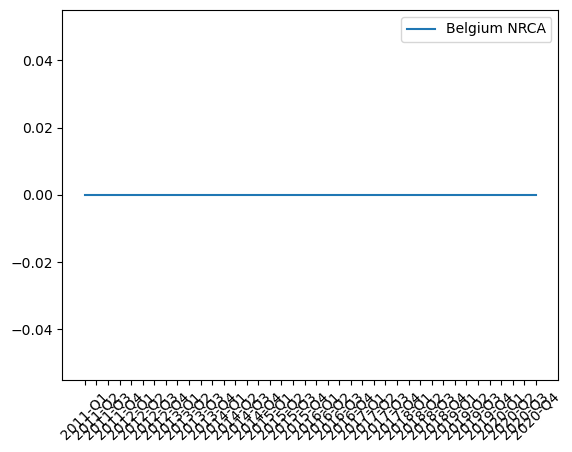

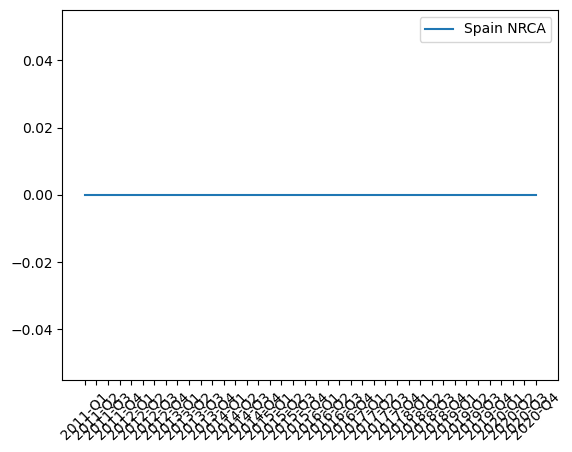

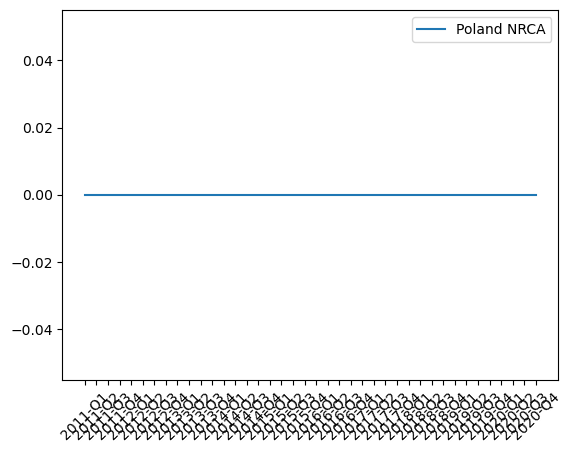

In [53]:
# Calculate and standardize NRCA scores
def calculate_nrca():
    for country in countries:
        combined[f"{country}_NRCA"] = sum(combined[f"std_share_{country}_{task}"] for task in task_columns)
        temp_mean = np.average(combined[f"{country}_NRCA"], weights=combined[f"share_{country}"])
        temp_sd = np.sqrt(np.average((combined[f"{country}_NRCA"] - temp_mean)**2, weights=combined[f"share_{country}"]))
        combined[f"std_{country}_NRCA"] = (combined[f"{country}_NRCA"] - temp_mean) / temp_sd

calculate_nrca()

# Plot NRCA scores over time
def plot_nrca():
    import matplotlib.pyplot as plt
    for country in countries:
        agg_country = combined.groupby("TIME")[f"std_{country}_NRCA"].sum().reset_index()
        plt.plot(agg_country["TIME"], agg_country[f"std_{country}_NRCA"], label=f"{country} NRCA")
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

plot_nrca()
